<h1><center>DATA EXPLORATION</center></h1>

We have collected information of over 6000 films from 1950 to 2018 including their director, cats, crew, budget, box-office revenues, running-time, and the genres they fall into. We have also obtained data about Academy Awards winners and nominees from 1955 to 2019 both at the level of films and the level of individuals. 

Our first goal is to explore the data and ensure consistency and integrity. We will then do some poreliminarfy analysis a out the various trends in predicting movie success b ased on revenues, IMDB votes and Academyy Award wins and nominations. 

Next, we will derive some new datasets which will be used for building and training our machine learning pipleines. The key factors we will be considering for training our models are the following:
1. Basic information about budget, revenues, IMDB ratings, length.
2. Movie genres of each film
3. Pre-oscar score computed based on the past awards and nominations of the cast, director, writer and technical staff of the film

In addition to the above, we will design a set of new features from existing features that may provide useful insights. These **derived variables** are:
1. Budget per actor: A measure of the amount spent on each cast member
2. Budget per time: A measure of amount spent per unit frame of the film
3. Runtime per actor: A measure of average screen-time allocated to each actor
4. Total ratings: To capture popularity (number of votes) and the ratings

And finally, we will be doing predictive modeling on the best film and best performance categories. The various cvategories will thus be aggregated into super-categories such as direction, performance, picture etc. 


In [51]:
# import necessary libraries
import pandas as pd
import collections
import numpy as np
import requests
import wikipedia
import re
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from urllib.request import urlopen
from scrapy import selector
import datetime as dt
import pickle
from skimage import io
from IPython.display import clear_output
%matplotlib inline

## Data Cleaning

THe acvquired data have been collected in the following data-structres and names: <br>
**Oscar categories and movie genres** THe hand-selected standard categories for the Acaemy Awards and the movie-genres are stored in the two followiong files. 
1. genre_dict = pickle.load(open("my_data_2/genre_dict","rb"))
2. main_categories_list = pickle.load(open("my_data_2/main_categories_list","rb")) 

The following dataframes have also been created:
1. df_oscars_films: DataFrame of films with wins('W'),nominations('N') or nothing('O') froim 1960 to 2019 oscars (films from 1959 to 2018)
2. df_oscars_individual: DataFRame of invidiaul categories (direcvtorsm, actors, supporting actrors, music, editing, etc)
3. df_imdb: Dataframe of movies scraped from IMDB.com (:pages1,2,3) and Wikpedia cointaining imdbID, votes, ratings, budget, box_office, running_time and cast_size
4. movie_info_dict: Dictionary of movie information for all the films in the above data frames combined

In [52]:
# Get preselected oscars info: Genres (genre_dict) and main oscar categories (main_categories)
genre_dict = pickle.load(open("my_data_4/genre_dict","rb"))
all_categories = pickle.load(open("my_data_4/all_categories","rb")) 
major_categories = pickle.load(open("my_data_4/major_categories","rb")) 
minor_categories = pickle.load(open("my_data_4/minor_categories","rb")) 
print(major_categories)

#OSCARS information
df_oscars_wide = pd.read_csv('my_data_4/df_oscars_wide.csv', index_col=[0])
df_oscars_long = pd.read_csv('my_data_4/df_oscars_long.csv', index_col=[0])
df_individual_long = pd.read_csv('my_data_4/df_individual_long.csv', index_col=[0])

# Movie information (PRE 2018)
movie_dict = pickle.load(open("my_data_4/movie_dict","rb"))
df_movies = pd.read_csv('my_data_4/df_movies.csv', index_col=[0])

# Remove outliers
df_movies = df_movies[(df_movies.budget>0) & (df_movies.budget<500)&
                      (df_movies.box_office > 0)&(df_movies.box_office < 5000)&
                      (df_movies.n_votes > 1000)&(df_movies.running_time>0)&
                      (df_movies.year>=1960)& (df_movies.year<2019)]
df_movies.reset_index(inplace=True,drop=True)

print(f'\nTotal movies in movie dataframe: {df_movies.shape[0]}')
print(f"No. of movies duplicated is {len(df_movies[df_movies.duplicated()])}")
print(f'Total movies in oscar dataframe: {len(df_oscars_wide.film.unique())}')
print(f'Total Individuals (actors, directors, screenwriters etc.) in individual dataframe: {len(df_individual_long.name.unique())}')

df_movies.head()


['picture', 'director', 's_actor', 's_actress', 'actor', 'actress', 'screenplay']

Total movies in movie dataframe: 4581
No. of movies duplicated is 0
Total movies in oscar dataframe: 2521
Total Individuals (actors, directors, screenwriters etc.) in individual dataframe: 3378


,imdbID,title,year,n_votes,imdb_rating,budget,box_office,cast,genre,running_time,inflation_factor,budget_adjusted
0,tt0097626,johnny handsome,1989,8324,6.2,20.0,7.24,7,3,96,0.806452,16.129032
1,tt0120903,x-men,2000,545484,7.4,75.0,296.30,10,4,104,0.580720,43.554007
2,tt0077975,national lampoon's animal house,1978,106817,7.5,3.0,141.60,6,1,109,1.533742,4.601227
3,tt1649419,the impossible,2012,182949,7.6,45.0,198.10,3,3,113,0.435551,19.599815
4,tt1099212,twilight,1998,401686,5.2,385.0,3346.00,18,3,607,0.613497,236.196319


In [53]:
print(f'movie_dict is a dictionary containing information of {len(movie_dict)} movies')
df_movies.to_csv('my_data_4/df_movies_budget_adjusted.csv')

movie_dict is a dictionary containing information of 6541 movies


## The Derived Dataframe

In [54]:
##DF_MOVIES_DERIVED
df_derived = pd.DataFrame()
df_derived[['imdbID','title','year']]= df_movies[['imdbID','title','year']]
df_derived['budget_per_actor'] = df_movies.budget_adjusted/df_movies.cast
df_derived['budget_per_time'] = df_movies.budget_adjusted/df_movies.running_time
df_derived['runtime_per_actor'] = df_movies.running_time/df_movies.cast
df_derived['percent_revenue'] = 100*(df_movies.box_office - df_movies.budget)/df_movies.budget #relative, not adjusted
df_derived['total_ratings'] = df_movies.n_votes*df_movies.imdb_rating/1000

print(df_derived.shape)
print(df_movies.shape)
df_derived.to_csv("my_data_4/df_movies_derived.csv")
df_derived.head(3)

(4581, 8)
(4581, 12)


,imdbID,title,year,budget_per_actor,budget_per_time,runtime_per_actor,percent_revenue,total_ratings
0,tt0097626,johnny handsome,1989,2.304147,0.168011,13.714286,-63.800000,51.6088
1,tt0120903,x-men,2000,4.355401,0.418789,10.400000,295.066667,4036.5816
2,tt0077975,national lampoon's animal house,1978,0.766871,0.042213,18.166667,4620.000000,801.1275


## The Genre Dataframe

In [55]:
def get_movie_genres(df_movies, movie_dict, genre_dict):  
    """takes in the movie information and the genre dictionary and creates a 
    one hot encoded genre
    """
    columns = ['title', 'year', 'imdbID', 'book']  + list(set(genre_dict.values()))
    df_genre = pd.DataFrame(columns = columns)

    for row in df_movies.iterrows(): # go through each movie
        idx = row[0]
        if idx%500==0:
            clear_output()
            print(f'{idx}of {len(df_movies)}')
            
        df_genre.loc[idx,'title'] = row[1].title
        df_genre.loc[idx,'year'] = row[1].year
        df_genre.loc[idx,'imdbID'] = row[1].imdbID
        
        if (row[1].title, row[1].year) not in movie_dict:
            continue
        else:
            movie = movie_dict[(row[1].title,row[1].year)]
        
        if 'book' in movie and movie['book']=='yes':
            df_genre.loc[idx,'based_on_book']= 1
        else:
            df_genre.loc[idx,'based_on_book']=0
            
        if 'genre' in movie and movie['genre'] != None:
            for gen in movie['genre']:
                df_genre.loc[idx,gen]=1
        else:
            df_genre.loc[idx,'oth']=1

    return df_genre.fillna('0') 

In [56]:
%%time
df_movies_genres = get_movie_genres(df_movies, movie_dict, genre_dict)
print(df_genres.shape)
print(df_movies.shape)
df_genres.to_csv('my_data_4/df_movies_genres.csv')

4500of 4581
(4581, 31)
(4581, 12)
CPU times: user 19.6 s, sys: 194 ms, total: 19.8 s
Wall time: 19.8 s


# Overall Genre Distribution

The following distribution of genres acorss all movies considered. Drama is the most popular genre followed by comedy and action

Index(['spy', 'sup', 'hor', 'dys', 'thr', 'act', 'his', 'adv', 'dis', 'epi',
       'com', 'fan', 'ani', 'mys', 'dra', 'psy', 'mon', 'war', 'sci', 'mus',
       'cri', 'oth', 'pol', 'rom', 'bio'],
      dtype='object')
(4581, 25)
CPU times: user 246 ms, sys: 13.3 ms, total: 259 ms
Wall time: 265 ms


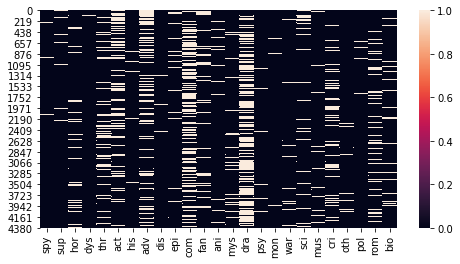

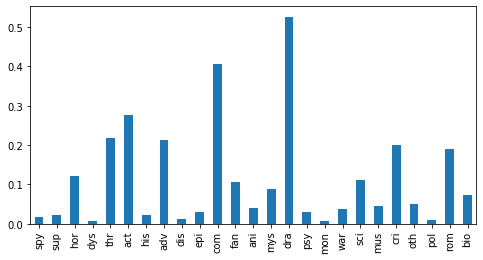

In [7]:
%%time
genre_matrix=df_genres.iloc[:,4:-2].astype('int64')# .values
columns = genre_matrix.columns
print(columns)
print(genre_matrix.shape)
type(genre_matrix)
# plt.imshow(genre_matrix)
plt.figure(figsize=(8,4))
sns.heatmap(genre_matrix)

x = genre_matrix.sum(axis=0)/len(genre_matrix)
plt.figure(figsize=(8,4))
x.plot.bar()
# plt.bar(genre_matrix.sum(axis=0)/len(genre_matrix))

## The Score Dataframe
Each movie will be assigned a prescore and a postscore. Ppre-score is the score of a film based on the track-record of its director, cast-members and other technical crew members. Post-score is based on the awards and nominations received by the film in the following year's Academy Awards.

First we will obtain the score dataframe for the oscar films and the individual nominees and winners.

In [8]:
def oscar_score(df_long,categories,years):
    """
    This returns an oscar score for each year and fategory, 
    both for films and individuals, based competition.
    """
    
    # initialize the score column
    scores = []
    df = pd.DataFrame()

    if categories == 'all':
        categories = pickle.load(open("my_data_3/all_categories","rb"))
    if type(categories)!=list:
        print('Error: Categories must be passed as a list')
        return
    for year in years:
        if year%10==0:
            clear_output()
            print('In decade:', year)
        for category in categories:
            # Only get winners and nominees for the year and category
            df_this = df_long[(df_long.year ==year) & (df_long.category==category)]
            if len(df_this)==0:
                print(f'Category {category} for {year} not avaialable')
                continue

            # Calculate score
            score = dict()
            n_wins = len(df_this[df_this.result=='W'])+len(df_this[df_this.result=='WN'])
            n_noms = len(df_this[df_this.result!='O'])
            
            if n_wins==0 or n_noms==0:
                print(f'No winner or nomination in {year} for category {category}')
                continue
            score['W']= min(5,n_noms/n_wins) # winner gets n points, more the competition, higher the point
            score['WN']= min(5,n_noms/n_wins)
            score['N']= 1/n_noms # nominees share, more the nominees , less each one gets 
            score['O']= 0 # else zero points (not needed, shown for consistency)
            scores = [score[x] for x in df_this.result]
            df_this['score']=scores
            scores = []
            df = df.append(df_this)
    return df

In [9]:
%%time
#DF_INDIVIDUAL_SCORE and DF_OSCAR_SCORE
categories = pickle.load(open("my_data_4/major_categories","rb"))
df_oscar_score = oscar_score(df_oscars_long,categories,range(1940,2019))
df_individual_score = oscar_score(df_individual_long,categories,range(1940,2019))

# SAVE
df_oscar_score.to_csv('my_data_4/df_oscar_score.csv')
df_individual_score.to_csv('my_data_4/df_individual_score.csv')

print(df_oscar_score.shape)
# print(df_oscar_score.query("result != 'O'").shape)
print(df_individual_score.shape)

In decade: 2010
(17397, 5)
(3064, 6)
CPU times: user 6.6 s, sys: 94.1 ms, total: 6.69 s
Wall time: 6.67 s


### Movie Scores
We use the Oscar Score and the Individual Score to obtain score for each movie

In [10]:
def prepost_oscar_score(df_mov, categories, movie_dict, df_indi_score, df_osc_score):
    """takes a year and title of a film and gives it a totla score based on Oscar records of actors, 
    directors and editorial crew
    """
    if categories == 'all':
                categories = pickle.load(open("my_data_4/all_categories","rb"))
    print("Categories:",categories)
    
    df_mov['prescore'] = 0 # initialize all socre to zero
    df_mov['postscore'] = 0
            
    for row in df_mov.iterrows(): # go through each movie
        idx = row[0]
        if idx%20==0:
            clear_output()
            print(categories)
            print(f'{idx}of {len(df_mov)}')
        title = row[1].title
        year = row[1].year
        if (title,year) in movie_dict:
            movie = movie_dict[title,year]
        else: 
            print(f'{title} in {year} missing in movie_dict')
            continue

        # get all_members from the infobox information in movie_dict
        score = 0
        checked_members = [] # to prevent double counting if any personnel is repeated (example: director and writer)
        
        # aggregate accross categories and members
        for field in movie:
            if type(movie[field])==list:
                for member in movie[field]:
                    if member in checked_members:
                        continue
                    checked_members.append(member)
                    for category in categories:
                        score = score + df_indi_score[(df_indi_score.year <year) & (df_indi_score.name == member)& 
                                                      (df_indi_score.category == category)].score.sum()
        
        df_mov.loc[idx,'prescore'] = score
        
        score = df_osc_score[df_osc_score.film == title].score.sum()
        df_mov.loc[idx,'postscore'] = score
    
    return df_mov

In [11]:
%%time
df_movies_oscars_prepost_score = prepost_oscar_score(df_movies[['imdbID','title','year']], categories, movie_dict, df_individual_score, df_oscar_score)
print(df_movies_oscars_prepost_score.shape)
print(df_movies.shape)
df_movies_oscars_prepost_score.head()


['picture', 'director', 's_actor', 's_actress', 'actor', 'actress', 'screenplay']
4580of 4581
(4581, 5)
(4581, 12)
CPU times: user 17min 33s, sys: 7.63 s, total: 17min 41s
Wall time: 17min 44s


,imdbID,title,year,prescore,postscore
0,tt0097626,johnny handsome,1989,0.4,0.0
1,tt0120903,x-men,2000,5.4,0.0
2,tt0077975,national lampoon's animal house,1978,0.0,0.0
3,tt1649419,the impossible,2012,0.2,0.2
4,tt1099212,twilight,1998,0.0,0.0


In [12]:
df_individual_long.query("name == 'James L. Brooks'")

,index,year,name,category,result
3995,0,1984,James L. Brooks,picture,W
4000,5,1984,James L. Brooks,director,W
4030,35,1984,James L. Brooks,screenplay,W
4323,1,1988,James L. Brooks,picture,N
4354,32,1988,James L. Brooks,screenplay,N
5048,2,1997,James L. Brooks,picture,N
5133,1,1998,James L. Brooks,picture,N


In [14]:
df_movies_oscars_prepost_score.to_csv('my_data_4/df_movies_oscars_prepost_score.csv')

## The Count DataFrame
Instead of scoring wins and nomination, we simply count them

### Precount

In [15]:
def pre_oscar_count(df_mov, categories, movie_dict, df_ind):
    """takes a year and title of a film and gives it a totla score based on Oscar records of actors, 
    directors and editorial crew
    """
    if categories == 'all':
                categories = pickle.load(open("my_data_3/main_categories","rb"))
    
    df_mov['precount_wins'] = 0 # initialize all socre to zero
    df_mov['precount_noms'] = 0
            
    for row in df_mov.iterrows(): # go through each movie
        idx = row[0]
        if idx%10==0:
            clear_output()
            print(f'{idx}of {len(df_mov)}')
        title = row[1].title
        year = row[1].year
        if (title,year) in movie_dict:
            movie = movie_dict[title,year]
        else: 
            print(f'{title} in {year} missing in movie_dict')
            continue

        # get all_members from the infobox information in movie_dict
        count_wins = 0
        count_noms = 0
        checked_members = [] # to prevent double counting if any personnel is repeated (example: director and writer)

        
        # aggregate accross categories and members
        for field in movie:
            if type(movie[field])==list:
                for member in movie[field]:
                    if member in checked_members:
                        continue
                    checked_members.append(member)
                    for cat in categories:
                        df_this = df_ind[(df_ind.name == member)&(df_ind.category == cat)&(df_ind.year<=year)]
                        series = df_this.result.value_counts()
                        if 'W' in series:
                            count_wins = count_wins + series['W']
                            # print('W', cat, member, series['W'])
                        if 'N' in series:
                            count_noms = count_noms + series['N']
                            # print('N', cat, member, series['N'])
        
        df_mov.loc[idx,'precount_wins'] = count_wins
        df_mov.loc[idx,'precount_noms'] = count_noms
        
    
    return df_mov


In [16]:
%%time
categories = pickle.load(open("my_data_4/major_categories","rb"))
df_movies_oscars_precount = pre_oscar_count(df_movies[['imdbID','title','year']], categories, movie_dict, df_individual_long)


4580of 4581


NameError: name 'df_movies_oscar_precount' is not defined

In [19]:
print(df_movies_oscars_precount.shape)
print(df_movies.shape)
df_movies_oscars_precount.head()

(4581, 5)
(4581, 12)


,imdbID,title,year,precount_wins,precount_noms
0,tt0097626,johnny handsome,1989,0,2
1,tt0120903,x-men,2000,1,2
2,tt0077975,national lampoon's animal house,1978,0,0
3,tt1649419,the impossible,2012,0,1
4,tt1099212,twilight,1998,0,0


In [20]:
df_movies_oscars_precount.query("title == 'inside llewyn davis'")

,imdbID,title,year,precount_wins,precount_noms
2435,tt2042568,inside llewyn davis,2013,4,9


In [21]:
df_movies_oscars_precount.to_csv('my_data_4/df_movies_oscars_precount.csv')

### Postcount

In [22]:
def post_oscar_count(df_mov,df_osc,categories):
    """
    This returns an oscar count for each year and film: 
    number of wins and nominations
    """
    
    # initialize the score column
    
    scores = []
    df = pd.DataFrame()
    df_missing = pd.DataFrame()
    df_mov['win'] = 0
    df_mov['nom'] = 0
    df_mov['none'] = 0
    
    df_osc.reset_index()
    
    for row in df_osc.iterrows():
        idx = row[0]
        film = row[1].film
        year= row[1].year
        title=film
        
        if idx%10:
            clear_output()

        wins = 0
        noms = 0
        nons = 0
        for cat in categories:
            # series = df_oscars[df_this.category==cat].result.value_counts()
            if row[1][cat] == 'W':
                wins = wins + 1
            if row[1][cat] == 'N':
                noms = noms + 1
            if row[1][cat] == 'O':
                nons = nons + 1
            if row[1][cat] == 'WN':
                wins = wins + 1
                noms = noms + 1
    
#             # df.loc[film, 'year']=year
#             df.loc[idx, 'film'] = film
#             df.loc[idx, 'year'] = year
#             df.loc[idx, 'win'] = wins
#             df.loc[idx, 'nom'] = noms
#             df.loc[idx, 'none'] = nons
            
            this = df_mov[(df_mov.title==title) & (df_mov.year==year)]
            if len(this) == 0:
                print(f'WARNING: Oscar nominated film {title} in year {year} missing from df_movies ')
                df_missing = df_missing.append(row[1])
            if len(this) > 1:
                print(f'WARNING: Oscar nominated film {title} in year {year} multiple entries')
            if len(this) == 1:
                idx2 = this.index[0]
                df_mov.loc[idx2,'win'] = wins
                df_mov.loc[idx2,'nom'] = noms+wins
                df_mov.loc[idx2,'none'] = nons
            
#     df.year = df.year.astype('int').astype('str')
#     x = pd.to_datetime(df.year, format='%Y', exact=True)
#     df.year = [x.year for x in pd.to_datetime(df.year, format='%Y', exact=True)]
    return df_mov, df_missing

In [23]:
%%time
categories = pickle.load(open("my_data_4/major_categories","rb"))
df_osc = df_oscars_wide[df_oscars_wide.year >=1960]
df_movies_oscars_postcount, df_missing = post_oscar_count(df_movies[['imdbID','title','year']],df_osc,categories)
print(df_movies_oscars_postcount.shape)
print(df_movies.shape)


(4581, 6)
(4581, 12)
CPU times: user 52.7 s, sys: 2.65 s, total: 55.3 s
Wall time: 54.4 s


In [24]:
df_movies_oscars_postcount.to_csv('my_data_4/df_movies_oscars_postcount.csv')

In [26]:
print(df_movies_oscars_postcount.shape)
print(f'{len(df_missing.film.unique())} Oscar nomnaited movies mising from df_movies')

(4581, 6)
520 Oscar nomnaited movies mising from df_movies


In [27]:
# np.sort(df_missing.film.unique())

## Outcomes DataFrame

In [30]:
df_movies_oscars_postcount.sort_values(by='nom', ascending=False).head()

,imdbID,title,year,win,nom,none
385,tt0299658,chicago,2002,2,7,1
1191,tt0086425,terms of endearment,1983,5,7,2
2347,tt0077362,coming home,1978,3,7,0
4548,tt0055031,judgment at nuremberg,1961,2,7,1
533,tt1045658,silver linings playbook,2012,1,7,0


In [34]:
df_movies_outcome = df_movies_oscars_postcount[['imdbID','title','year','win','nom']]
outcome = lambda x,th : 1 if x>=th else 0
thresh,criteria = 1,'nom' # 1 or more nomination
df_movies_outcome['outcome'] = [outcome(x,thresh) for x in df_movies_outcome[criteria]]
df_movies_outcome.head()

,imdbID,title,year,win,nom,outcome
0,tt0097626,johnny handsome,1989,0,0,0
1,tt0120903,x-men,2000,0,0,0
2,tt0077975,national lampoon's animal house,1978,0,0,0
3,tt1649419,the impossible,2012,0,1,1
4,tt1099212,twilight,1998,0,0,0


In [36]:
df_movies_outcome.sort_values(by='win',ascending=False).head()

,imdbID,title,year,win,nom,outcome
1207,tt0079417,kramer vs. kramer,1979,5,7,1
831,tt0073486,one flew over the cuckoo's nest,1975,5,6,1
1191,tt0086425,terms of endearment,1983,5,7,1
452,tt0102926,the silence of the lambs,1991,5,5,1
787,tt0477348,no country for old men,2007,4,4,1


In [37]:
###########################  SANITY CHECK  #######################
#df_movies
#df_movies_dervied
#df_genres
#df_movies_oscars_precount
#df_movies_oscars_postcount
#df_movies_oscars_prepost_score

print(df_movies.shape)
for row in df_movies.iterrows():
    idx = row[0]
    imdbID = row[1].imdbID
    err= 0
    
    if (df_derived.loc[idx,'imdbID'] != imdbID):
        print('Error in df_derived DataFrame')
        err+=1
    if (df_genres.loc[idx,'imdbID'] != imdbID):
        print('Error in df_genres DataFrame')
        err+=1
    if (df_movies_oscars_prepost_score.loc[idx,'imdbID'] != imdbID):
        print('Error in df_oscars_prepost_score DataFrame')
        err+=1
    if (df_movies_oscars_precount.loc[idx,'imdbID'] != imdbID):
        print('Error in df_oscars_precount DataFrame')
        err+=1
    if (df_movies_oscars_postcount.loc[idx,'imdbID'] != imdbID):
        print('Error in df_genres DataFrame')
        err+=1
    if (df_movies_outcome.loc[idx,'imdbID'] != imdbID):
        print('Error in df_outcome DataFrame')
        err+=1
print('Number of errors:',err)
        

(4581, 12)
Number of errors: 0


In [49]:
# The Mega DataFrame

df = df_movies
df = pd.merge(df,df_derived)
df = pd.merge(df,df_genres)
df = pd.merge(df,df_movies_oscars_prepost_score)
df = pd.merge(df,df_movies_oscars_precount)
df = pd.merge(df,df_movies_oscars_postcount)
# df = pd.merge(df,df_movies_outcome)
print(df.shape)
print(f'{len(df.columns)} columns')
print(df.columns)
df.head()
df.to_csv('my_data_4/DF_MEGA.csv')





(4581, 52)
52 columns
Index(['imdbID', 'title', 'year', 'n_votes', 'imdb_rating', 'budget',
       'box_office', 'cast', 'genre', 'running_time', 'inflation_factor',
       'budget_adjusted', 'budget_per_actor', 'budget_per_time',
       'runtime_per_actor', 'percent_revenue', 'total_ratings', 'book', 'spy',
       'sup', 'hor', 'dys', 'thr', 'act', 'his', 'adv', 'dis', 'epi', 'com',
       'fan', 'ani', 'mys', 'dra', 'psy', 'mon', 'war', 'sci', 'mus', 'cri',
       'oth', 'pol', 'rom', 'bio', 'based_on_book', 'other', 'prescore',
       'postscore', 'precount_wins', 'precount_noms', 'win', 'nom', 'none'],
      dtype='object')


In [50]:
df.query("title == 'titanic'")

,imdbID,title,year,n_votes,imdb_rating,budget,box_office,cast,genre,running_time,...,bio,based_on_book,other,prescore,postscore,precount_wins,precount_noms,win,nom,none
6,tt0120338,titanic,1997,983627,7.8,200.0,2187.0,10,4,195,...,0,0.0,0,5.4,10.4,1,2,2,4,3


# 2019 Movies Information

1. df_movies_2019
2. df_movies_derived_201
3. df_movies_genres_2019
4. df_movies_oscars_precount_2019
5. df_movies_oscars_prepost_score_2019

In [ ]:
# df_movies_2019 = pd.read_csv('my_data_4/df_movies_2019.csv', index_col=[0])
# len(df_movies_2019[df_movies_2019.imdbID.duplicated() == True])

In [ ]:
# movies_2019 = [];
# title = 'the last black man in san francisco'
# df = df_movies_2019[df_movies_2019.title == title]
# if len(df)==1:
#     movies_2019.append(title)
# df.head()   

In [ ]:
# movies_2019